In [1]:
import pandas as pd
pd.options.plotting.backend = "plotly"

# Train data

In [5]:
train = pd.read_csv('~/OneDrive/Data/Load/Commercial/bayfield_jail-courthouse_load_persist_210829_240608_1min.csv',
                    index_col=0, parse_dates=True, comment='#').resample('60min').mean()
train = train.iloc[:24*int(0.95*len(train)//24)]
train.columns = ['true','pers']
train

,true,pers
Datetime CST,,
2021-08-29 00:00:00,62.129847,61.508176
2021-08-29 01:00:00,61.888739,61.086359
2021-08-29 02:00:00,61.294570,60.584481
2021-08-29 03:00:00,62.093739,59.919298
2021-08-29 04:00:00,63.880559,61.285163
...,...,...
2024-04-17 19:00:00,82.003698,71.086875
2024-04-17 20:00:00,78.309506,73.728267
2024-04-17 21:00:00,73.084148,71.131879


In [6]:
train['e_pers'] = train.pers - train.true

print(pd.DataFrame(train.e_pers.values.reshape(-1,24).mean(axis=0)))

pd.DataFrame(train.e_pers.values.reshape(-1,24)).plot(kind='box')

           0
0  -0.001400
1  -0.003451
2   0.000455
3   0.003347
4   0.045151
5   0.055707
6   0.028389
7   0.033142
8   0.034194
9   0.034560
10  0.036875
11  0.039965
12  0.032767
13  0.023443
14  0.027597
15  0.005158
16  0.003329
17  0.014918
18  0.011090
19 -0.014349
20 -0.011940
21 -0.007813
22 -0.011221
23  0.002807


# Forecasts

In [6]:
#filepath = '/home/mjw/Code/LSTMforecast/results/bayfield_jail-courthouse/'
filepath = '/home/mjw/Code/LSTMforecast/results/bayfield_jail-courthouse_v1.2/'
#filepath = '/home/mjw/Code/LSTMforecast/moresultsdels/bayfield_jail-courthouse_random-search/'
#filepath = '/home/mjw/Code/LSTMforecast/results/bayfield_jail-courthouse_random-search/'
#filepath = '../models/bayfield_jail-courthouse_i96_o96_imf4569_rmWKEND_u128-128_d0.1-0.1/'
df = pd.read_csv(filepath+'all_forecasts.csv',index_col=0)

df['timestamp_update'] = pd.to_datetime(df['timestamp_update'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['weekday'] = df['timestamp_update'].dt.dayofweek

first_monday = df.loc[df['weekday'] == 0,'timestamp_update'].iloc[0]

df = df.loc[df['timestamp_update'].values >= first_monday,:]

df

,Pred,Load,Persist,timestamp_update,timestamp,weekday
4608,61.826836,59.368459,62.827204,2024-04-22 00:00:00,2024-04-22 00:00:00,0
4609,61.739544,60.558653,60.171424,2024-04-22 00:00:00,2024-04-22 00:15:00,0
4610,61.688698,59.204911,62.853531,2024-04-22 00:00:00,2024-04-22 00:30:00,0
4611,61.657875,59.694957,58.840286,2024-04-22 00:00:00,2024-04-22 00:45:00,0
4612,61.771114,58.747861,62.632080,2024-04-22 00:00:00,2024-04-22 01:00:00,0
...,...,...,...,...,...,...
80635,69.582565,78.573146,74.623892,2024-06-05 23:00:00,2024-06-06 21:45:00,2
80636,69.904680,75.299217,74.636369,2024-06-05 23:00:00,2024-06-06 22:00:00,2
80637,69.684830,77.633942,72.685377,2024-06-05 23:00:00,2024-06-06 22:15:00,2
80638,69.069690,73.523607,76.456359,2024-06-05 23:00:00,2024-06-06 22:30:00,2


# Daily update weekly plots (w/ offset)

Mean daily skill: 10%
Daily skills > 0: 70%


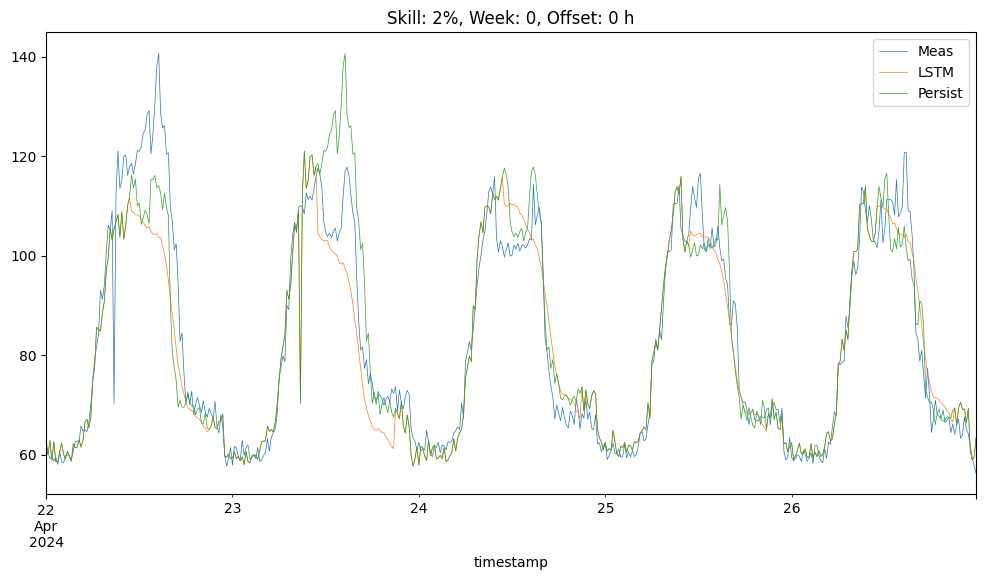

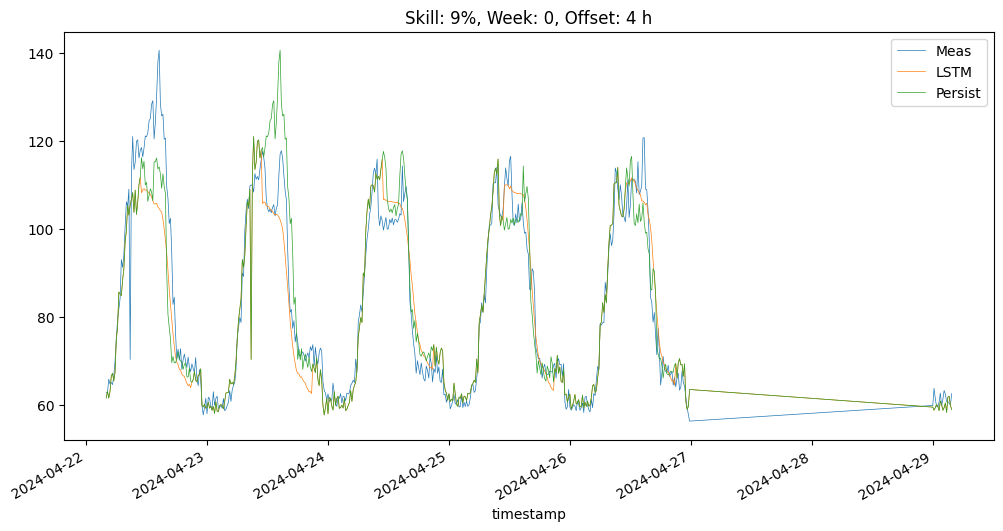

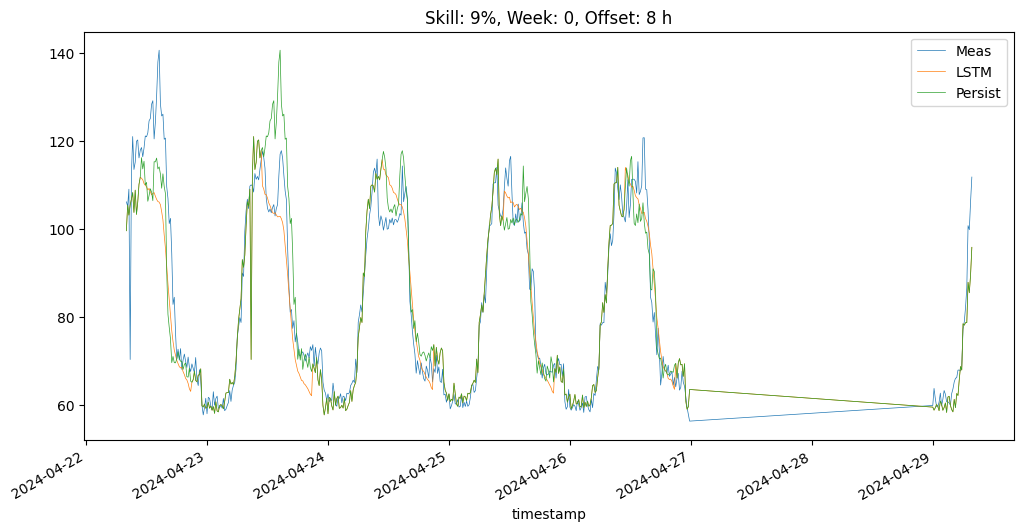

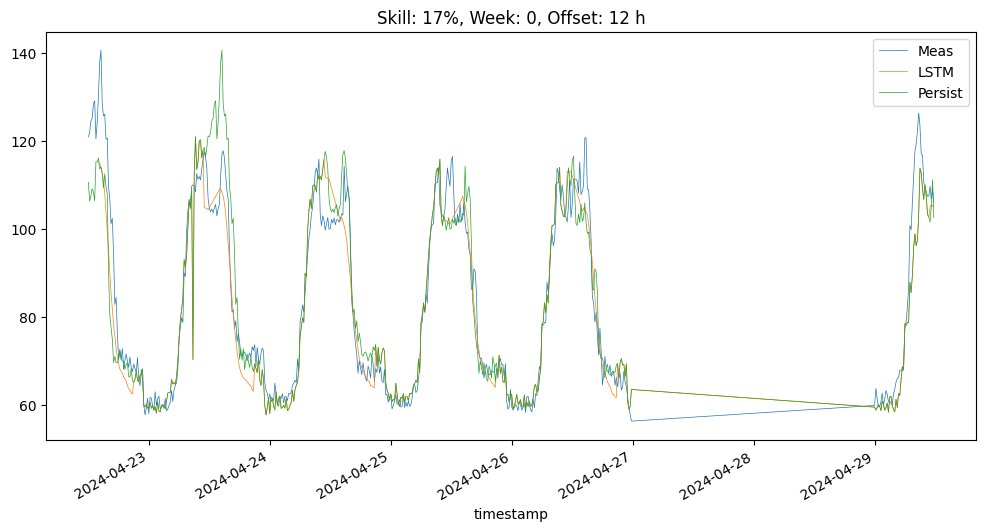

In [75]:
pd.options.plotting.backend = 'matplotlib'

h_offset = 8

skills = []
daily_skills = []
wk = 0
for h_offset in [0,4,8,12]:
#for wk in range(7):
    t0 = df['timestamp_update'].iloc[0] + pd.Timedelta(f'{h_offset}h') + wk*pd.Timedelta(f'7d')

    yweek = pd.DataFrame([])

    for t in pd.date_range(t0,periods=5,freq='1d'):
        y = pd.DataFrame({'Meas':df[df.timestamp_update==t]['Load'].iloc[:(5*96)].values,
                          'LSTM':df[df.timestamp_update==t]['Pred'].iloc[:(5*96)].values,
                          'Persist':df[df.timestamp_update==t]['Persist'].iloc[:(5*96)].values},
                            index=df[df.timestamp_update==t]['timestamp'].iloc[:(5*96)])


        y.iloc[:8,1] = pd.NA #y.iloc[:8,2].values

        #y.LSTM = y.LSTM * (y.Persist.mean() / y.LSTM.mean()) # scale by mean of persistence

        #h_persist = 3
        #y.loc[t:t+pd.Timedelta(hours=h_persist),'LSTM'] = y.loc[t:t+pd.Timedelta(hours=h_persist),'Persist'].values # fill in first few values of persistence

        h_offpeak = list(range(11)) + list(range(21,24))
        y.loc[y.index.hour.isin(h_offpeak),'LSTM'] = y.loc[y.index.hour.isin(h_offpeak),'Persist'].values

        #new_dfplot = pd.DataFrame({ 'True':y_true.values,'LSTM':y_lstm.values,'Persist':y_pers.values},index=idx)
        yweek = pd.concat((yweek,y),axis=0)

        skill_mae = 1 - (y.Meas - y.LSTM).abs().mean() / (y.Meas - y.Persist).abs().mean()
        skill_mse = 1 - (y.Meas - y.LSTM).pow(2).mean() / (y.Meas - y.Persist).pow(2).mean()
        daily_skills.append(skill_mae)
        

    skill_mae = 1 - (yweek.Meas - yweek.LSTM).abs().mean() / (yweek.Meas - yweek.Persist).abs().mean()
    skill_mse = 1 - (yweek.Meas - yweek.LSTM).pow(2).mean() / (yweek.Meas - yweek.Persist).pow(2).mean()
    
    skills.append(skill_mae)

    yweek = yweek.interpolate()

    yweek.plot(title=f'Skill: {100*skill_mae:.0f}%, Week: {wk}, Offset: {h_offset} h',figsize=(12,6),linewidth=0.5)

skills = pd.Series(daily_skills)
print(f'Mean daily skill: {100*skills.mean():.0f}%')
print(f"Daily skills > 0: {100*skills[skills.values>0].count()/len(skills):.0f}%")


Mean daily skill: 1%
Daily skills > 0: 43%


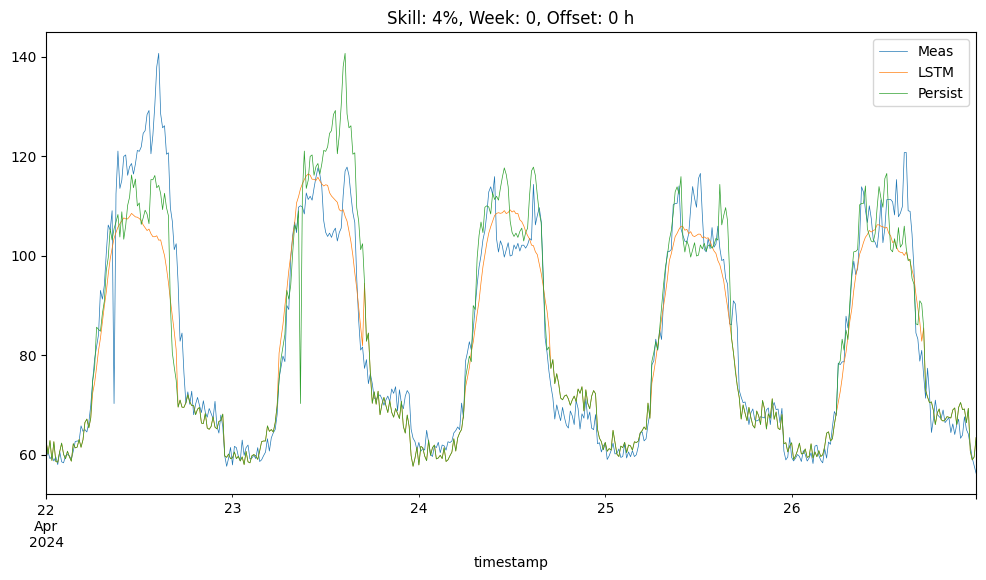

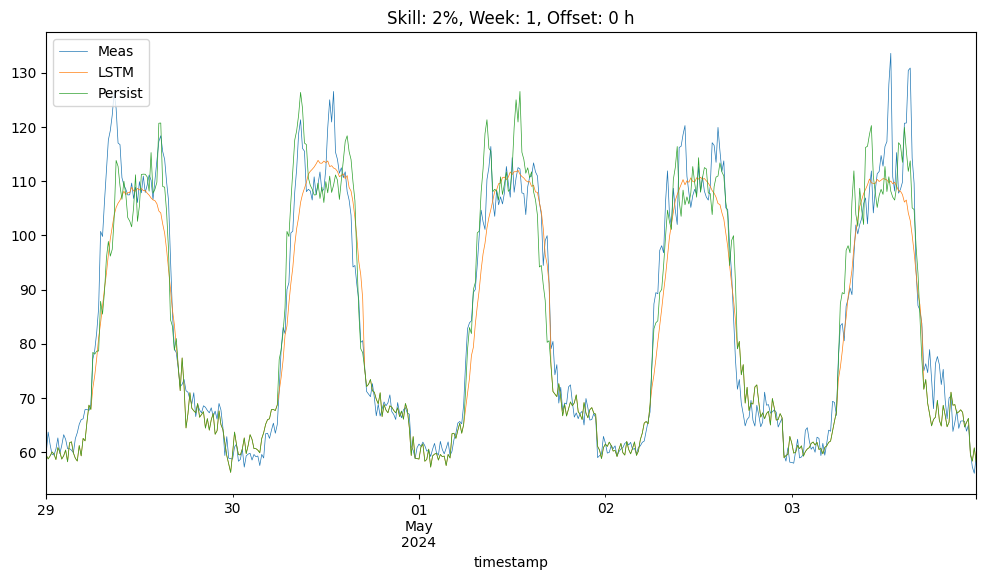

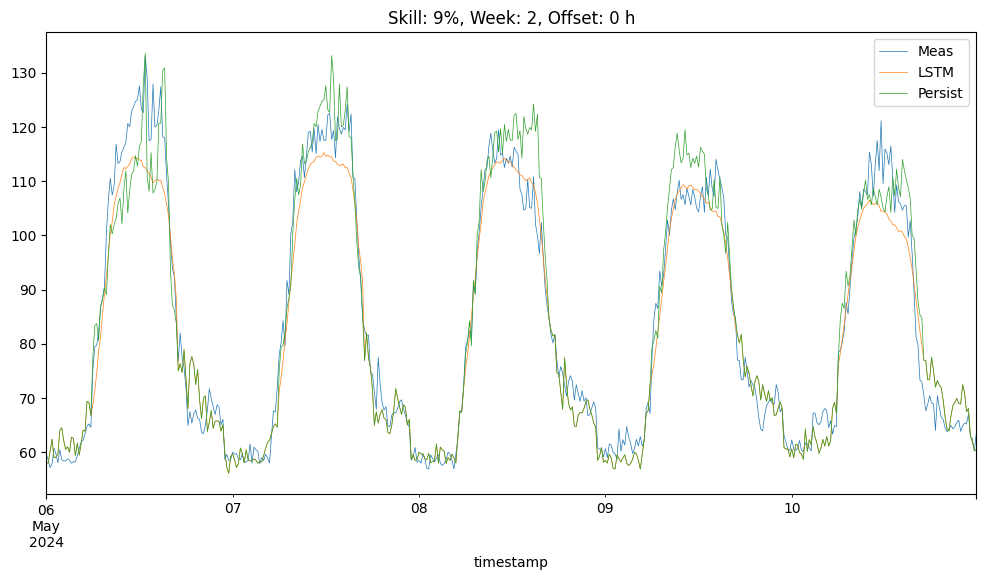

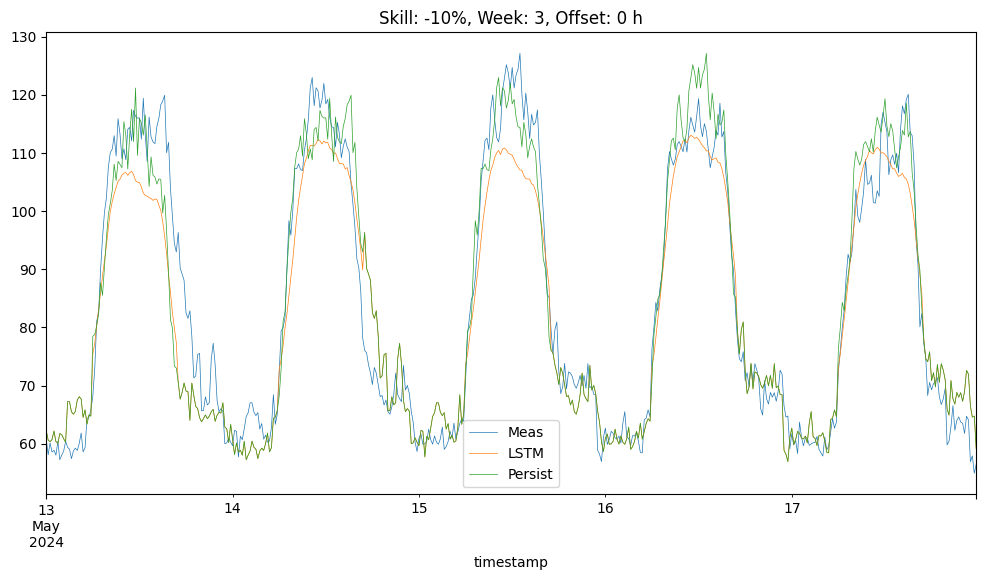

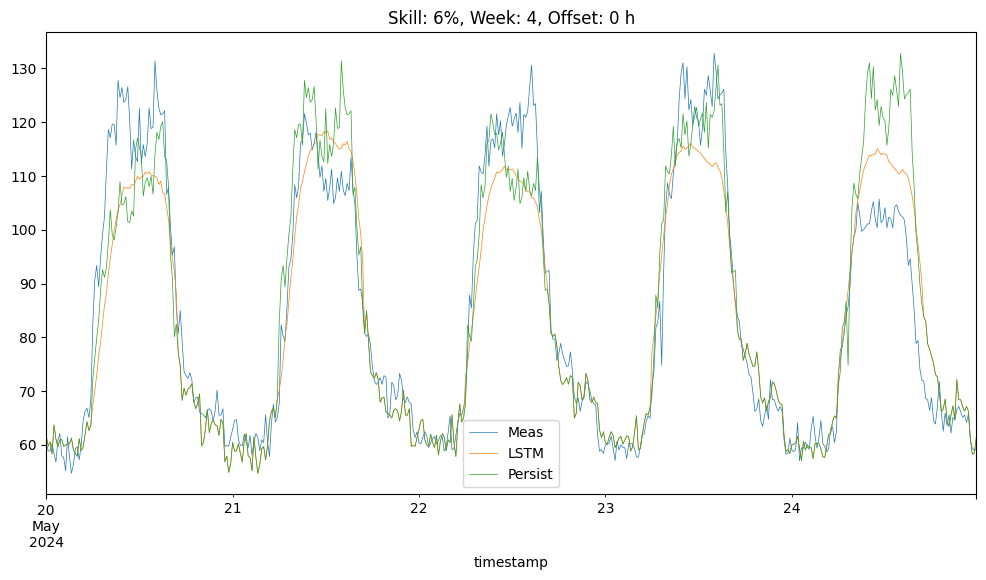

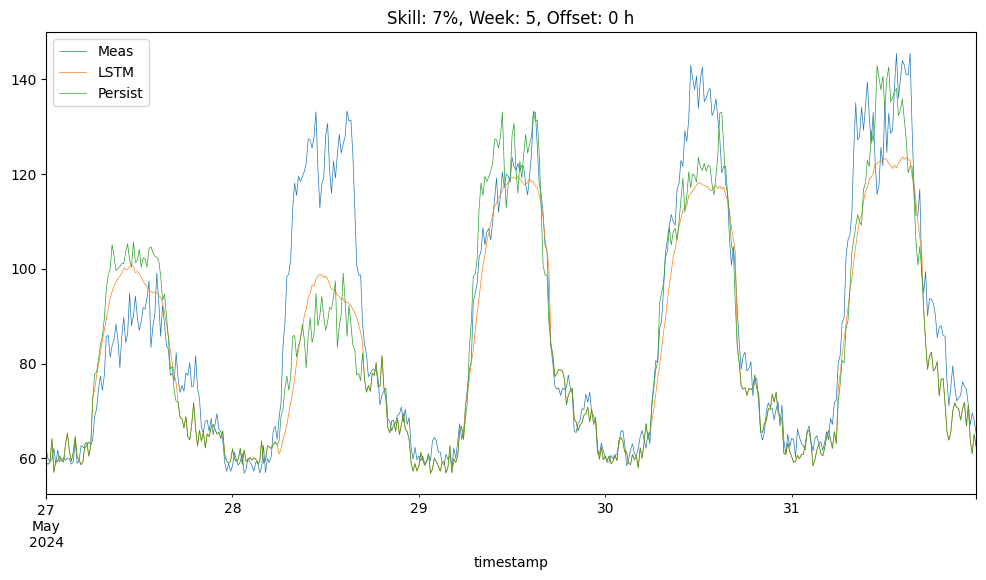

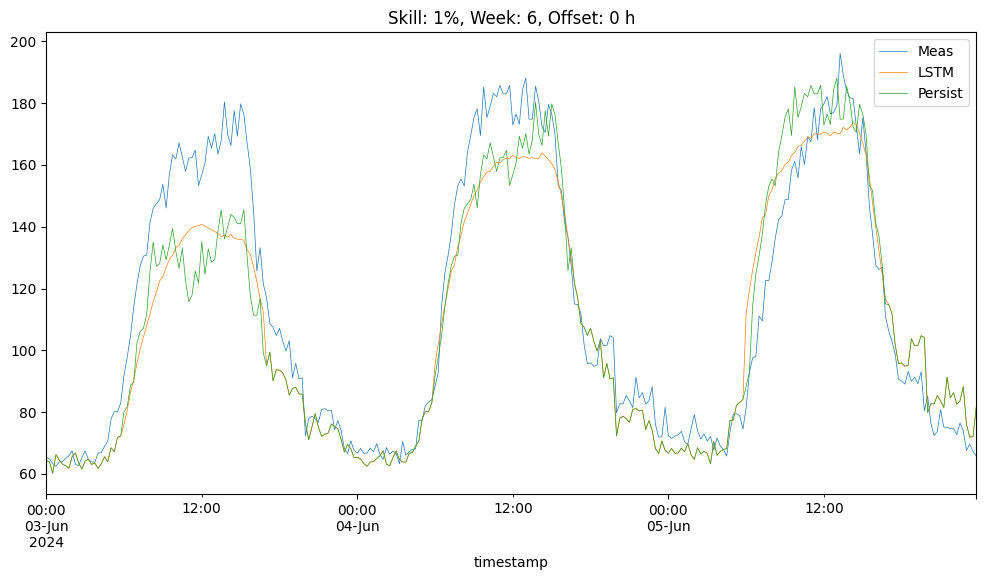

In [74]:
pd.options.plotting.backend = 'matplotlib'

h_offset = 8

skills = []
daily_skills = []
wk = 0
h_offset = 0
#for h_offset in [0,4,8,12]:
for wk in range(7):
    t0 = df['timestamp_update'].iloc[0] + pd.Timedelta(f'{h_offset}h') + wk*pd.Timedelta(f'7d')

    yweek = pd.DataFrame([])

    for t in pd.date_range(t0,periods=5,freq='1d'):
        y = pd.DataFrame({'Meas':df[df.timestamp_update==t]['Load'].iloc[:(5*96)].values,
                          'LSTM':df[df.timestamp_update==t]['Pred'].iloc[:(5*96)].values,
                          'Persist':df[df.timestamp_update==t]['Persist'].iloc[:(5*96)].values},
                            index=df[df.timestamp_update==t]['timestamp'].iloc[:(5*96)])


        y.iloc[:8,1] = pd.NA #y.iloc[:8,2].values

        #y.LSTM = y.LSTM * (y.Persist.mean() / y.LSTM.mean()) # scale by mean of persistence

        #h_persist = 3
        #y.loc[t:t+pd.Timedelta(hours=h_persist),'LSTM'] = y.loc[t:t+pd.Timedelta(hours=h_persist),'Persist'].values # fill in first few values of persistence

        h_offpeak = list(range(6)) + list(range(17,24))
        y.loc[y.index.hour.isin(h_offpeak),'LSTM'] = y.loc[y.index.hour.isin(h_offpeak),'Persist'].values

        #new_dfplot = pd.DataFrame({ 'True':y_true.values,'LSTM':y_lstm.values,'Persist':y_pers.values},index=idx)
        yweek = pd.concat((yweek,y),axis=0)

        skill_mae = 1 - (y.Meas - y.LSTM).abs().mean() / (y.Meas - y.Persist).abs().mean()
        skill_mse = 1 - (y.Meas - y.LSTM).pow(2).mean() / (y.Meas - y.Persist).pow(2).mean()
        daily_skills.append(skill_mae)
        

    skill_mae = 1 - (yweek.Meas - yweek.LSTM).abs().mean() / (yweek.Meas - yweek.Persist).abs().mean()
    skill_mse = 1 - (yweek.Meas - yweek.LSTM).pow(2).mean() / (yweek.Meas - yweek.Persist).pow(2).mean()
    
    skills.append(skill_mae)

    yweek = yweek.interpolate()

    yweek.plot(title=f'Skill: {100*skill_mae:.0f}%, Week: {wk}, Offset: {h_offset} h',figsize=(12,6),linewidth=0.5)

skills = pd.Series(daily_skills)
print(f'Mean daily skill: {100*skills.mean():.0f}%')
print(f"Daily skills > 0: {100*skills[skills.values>0].count()/len(skills):.0f}%")


Mean daily skill: 14%
Daily skills > 0: 71%


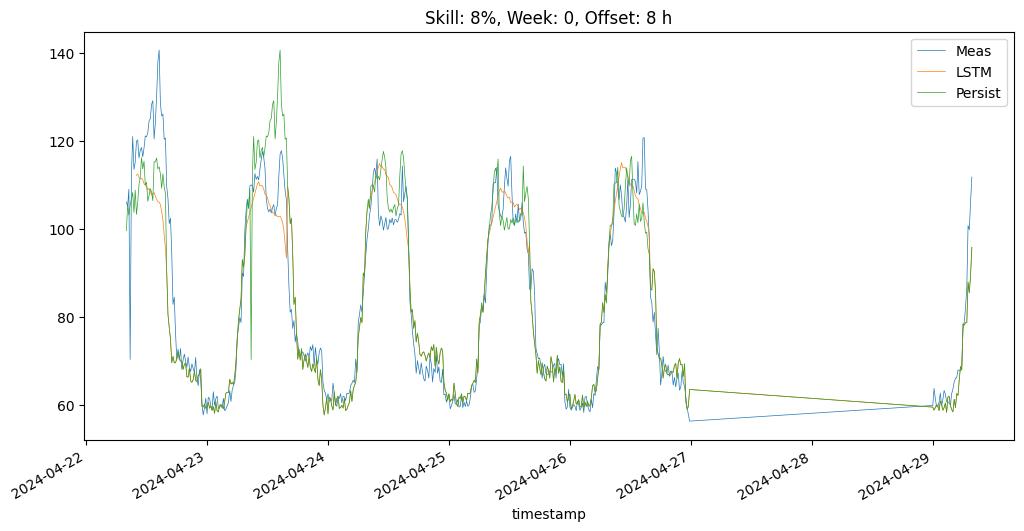

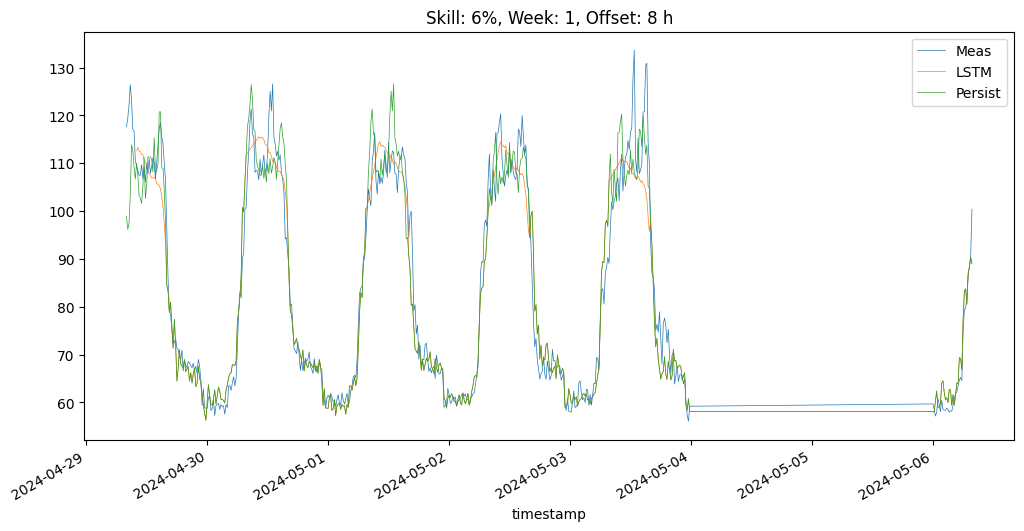

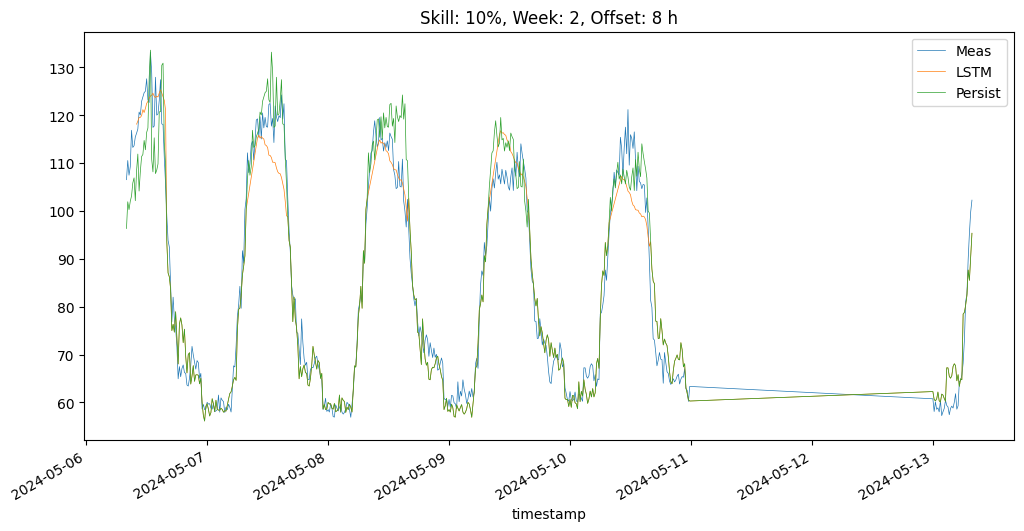

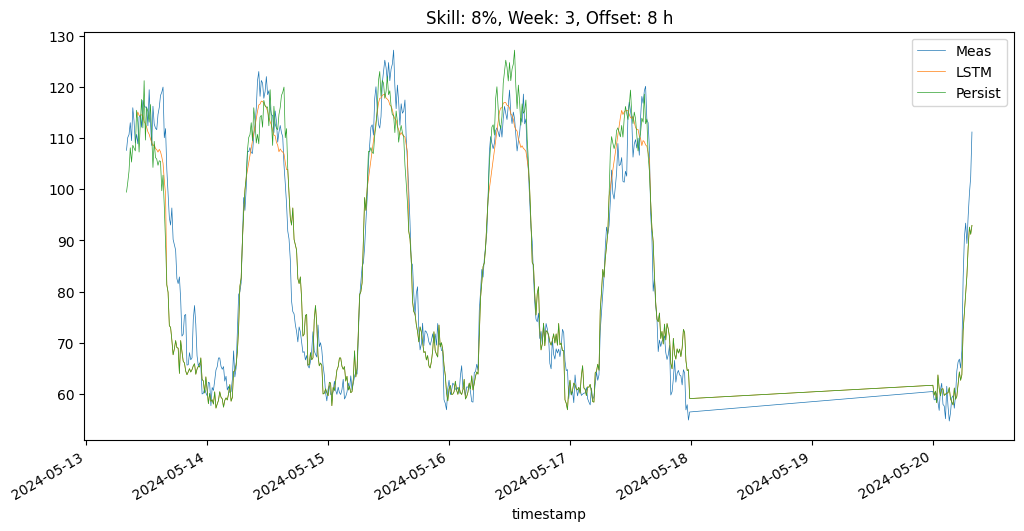

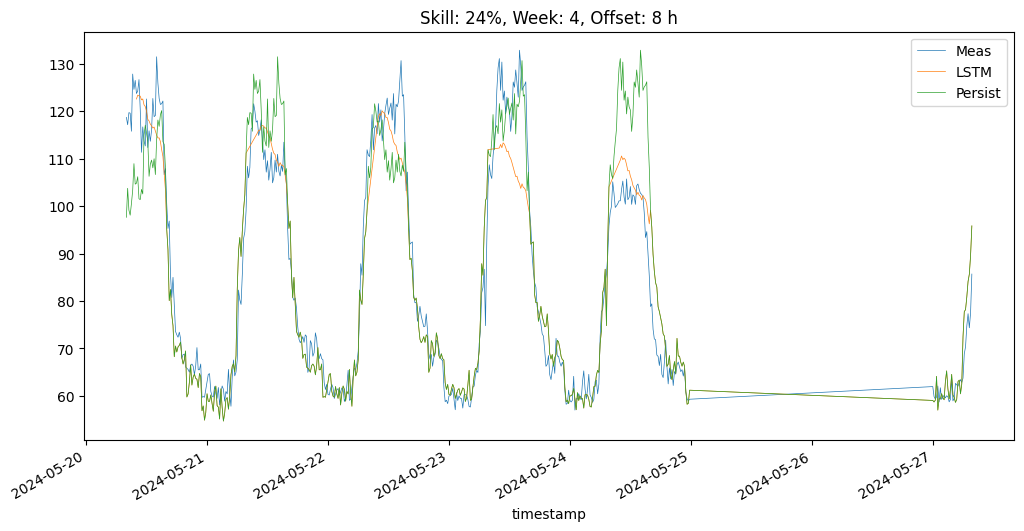

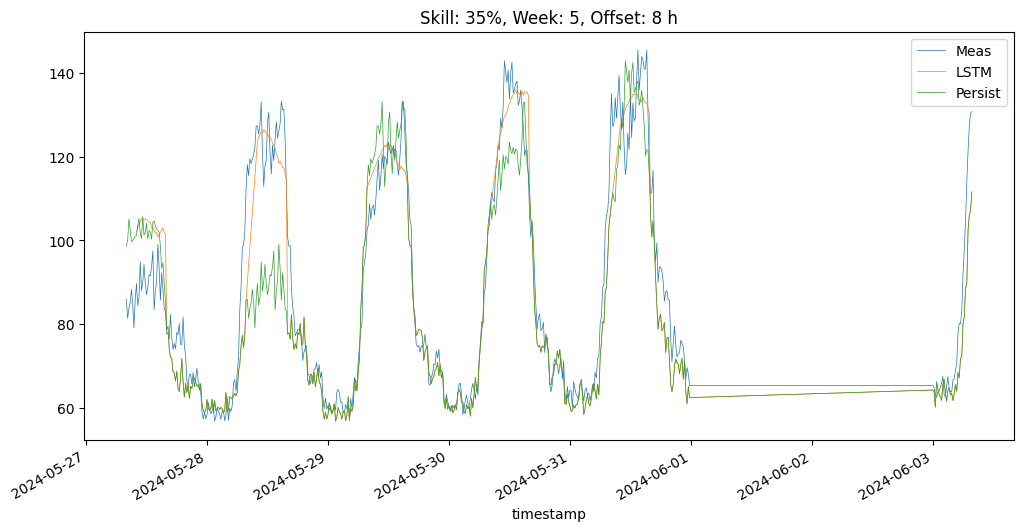

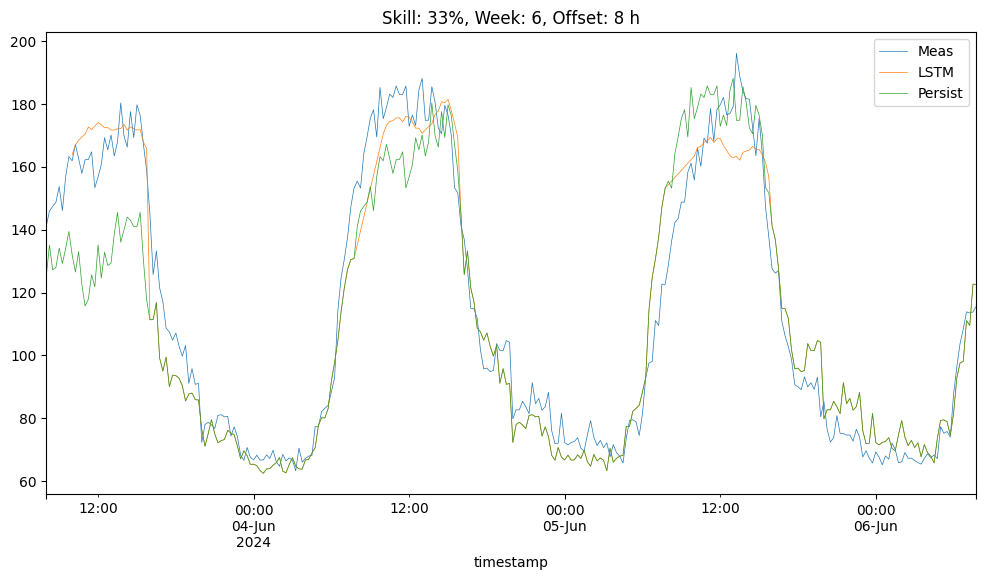

In [93]:
pd.options.plotting.backend = 'matplotlib'

h_offset = 8

skills = []
daily_skills = []
wk = 0
h_offset = 8
#for h_offset in [0,4,8,12]:
for wk in range(7):
    t0 = df['timestamp_update'].iloc[0] + pd.Timedelta(f'{h_offset}h') + wk*pd.Timedelta(f'7d')

    yweek = pd.DataFrame([])

    for t in pd.date_range(t0,periods=5,freq='1d'):
        y = pd.DataFrame({'Meas':df[df.timestamp_update==t]['Load'].iloc[:(5*96)].values,
                          'LSTM':df[df.timestamp_update==t]['Pred'].iloc[:(5*96)].values,
                          'Persist':df[df.timestamp_update==t]['Persist'].iloc[:(5*96)].values},
                            index=df[df.timestamp_update==t]['timestamp'].iloc[:(5*96)])


        y.iloc[:8,1] = pd.NA #y.iloc[:8,2].values

        #y.LSTM = y.LSTM * (y.Persist.mean() / y.LSTM.mean()) # scale by mean of persistence

        #h_persist = 2
        #y.loc[t:t+pd.Timedelta(hours=h_persist),'LSTM'] = y.loc[t:t+pd.Timedelta(hours=h_persist),'Persist'].values # fill in first few values of persistence

        h_offpeak = list(range(8)) + list(range(16,24))
        y.loc[y.index.hour.isin(h_offpeak),'LSTM'] = y.loc[y.index.hour.isin(h_offpeak),'Persist'].values

        #new_dfplot = pd.DataFrame({ 'True':y_true.values,'LSTM':y_lstm.values,'Persist':y_pers.values},index=idx)
        yweek = pd.concat((yweek,y),axis=0)

        skill_mae = 1 - (y.Meas - y.LSTM).abs().mean() / (y.Meas - y.Persist).abs().mean()
        skill_mse = 1 - (y.Meas - y.LSTM).pow(2).mean() / (y.Meas - y.Persist).pow(2).mean()
        daily_skills.append(skill_mae)
        

    skill_mae = 1 - (yweek.Meas - yweek.LSTM).abs().mean() / (yweek.Meas - yweek.Persist).abs().mean()
    skill_mse = 1 - (yweek.Meas - yweek.LSTM).pow(2).mean() / (yweek.Meas - yweek.Persist).pow(2).mean()
    
    skills.append(skill_mae)

    yweek = yweek.interpolate()

    yweek.plot(title=f'Skill: {100*skill_mae:.0f}%, Week: {wk}, Offset: {h_offset} h',figsize=(12,6),linewidth=0.5)

skills = pd.Series(daily_skills)
print(f'Mean daily skill: {100*skills.mean():.0f}%')
print(f"Daily skills > 0: {100*skills[skills.values>0].count()/len(skills):.0f}%")
